## 1. Loading Required Packages

In [53]:
# Standard libraries
import sys
sys.path.append('../../')

import itertools

# Data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# FinRL and stable_baselines3 for machine learning and trading
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_primo_trading.env_primorl import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.logger import configure

# Configuration files and helper functions from FinRL
from finrl.config import INDICATORS, FUNDAMENTAL_INDICATORS
from finrl.main import check_and_make_directories

# Enabling chart display within Jupyter notebook
%matplotlib inline

TRAINED_MODEL_DIR = 'trained_models_primorl'
RESULTS_DIR = 'results_primorl'
DATA_DIR = 'data_primorl'

# Checking and creating directories
check_and_make_directories([TRAINED_MODEL_DIR, DATA_DIR])

## 2. Data Retrieval

We have a class called YahooDownloader that uses yfinance to fetch data from Yahoo Finance.

In the YahooDownloader of FinRL, we modified the data frame into a format suitable for further data processing. We use a custom closing price instead of the regular closing price and add a column that represents the day of the week (0-4 corresponding to Monday-Friday).

In [54]:
# Training and trading intervals
TRAIN_START_DATE = '2022-04-01'
TRAIN_END_DATE = '2024-07-31'
TRADE_START_DATE = '2024-08-01'
TRADE_END_DATE = '2025-02-28'

Učitavamo podatke iz CSV datoteke koja sadrži generirane značajke od strane GPT-4 modela.

In [55]:
gpt_predictions = pd.read_csv('data/AMZN_data.csv')

# Renaming the column 'Date' to 'date'
gpt_predictions = gpt_predictions.rename(columns={'Date': 'date'})

gpt_predictions.head()

,date,Adj Close Price,Returns,Bin Label,News Relevance,Sentiment,Price Impact Potential,Trend Direction,Earnings Impact,Investor Confidence,Risk Profile Change,Prompt
0,2022-04-04,168.346497,0.029264,U3,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...
1,2022-04-05,164.054993,-0.025492,D3,2,1,1,1,1,2,0,\n [COMPANY BASICS]\n ...
2,2022-04-06,158.755997,-0.032300,D4,2,1,1,1,1,2,0,\n [COMPANY BASICS]\n ...
3,2022-04-07,157.784500,-0.006119,D1,2,0,-1,0,0,0,0,\n [COMPANY BASICS]\n ...
4,2022-04-08,154.460495,-0.021067,D3,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...


In [56]:
# Fetching all data
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                         end_date = TRADE_END_DATE,
                         ticker_list = ['AMZN']).fetch_data()

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (729, 8)


In [57]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2022-04-01,163.559998,163.559998,165.826996,164.149506,57090000,AMZN,4
1,2022-04-04,168.346497,168.346497,168.394501,164.125000,49882000,AMZN,0
2,2022-04-05,164.054993,164.054993,168.110504,167.741501,53728000,AMZN,1
3,2022-04-06,158.755997,158.755997,162.199997,161.650497,79056000,AMZN,2
4,2022-04-07,157.784500,157.784500,160.078995,158.399994,68136000,AMZN,3


## 3. Data Processing

We use the defined class FeatureEngineer to process data and add technical indicators.

The use_vix option includes the VIX index, known as the "fear index," which represents the expected volatility of the stock market based on S&P 500 options. The VIX helps the model understand market uncertainty, with higher values indicating greater uncertainty.

The use_turbulence option includes the turbulence index, which measures unusual market fluctuations and serves as an indicator of risk and market shocks. It is useful for identifying periods of high volatility, helping the model to adapt to financial crises.

Overall, a quite handy class that contains useful methods for processing financial data and can be applied to numerous other purposes.

In [58]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=False,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

[*********************100%***********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (728, 8)
Successfully added vix


In [59]:
# Create a list of unique stock tickers from the 'tic' column of the 'processed' DataFrame.
list_ticker = processed["tic"].unique().tolist()

# Create a list of dates between the earliest and latest dates in the 'processed' DataFrame, converting them to strings.
list_date = list(pd.date_range(processed['date'].min(), processed['date'].max()).astype(str))

# Create combinations of all dates and stock tickers using the Cartesian product.
combination = list(itertools.product(list_date, list_ticker))

# Create a new DataFrame 'processed_full' with columns "date" and "tic", containing all combinations of dates and stock tickers.
# Merge this DataFrame with the original 'processed' DataFrame based on the "date" and "tic" columns, using a 'left' join.
processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(processed, on=["date", "tic"], how="left")

# Filter the 'processed_full' DataFrame to contain only those rows whose dates are present in the original 'processed' DataFrame.
processed_full = processed_full[processed_full['date'].isin(processed['date'])]

# Sort the 'processed_full' DataFrame by date and stock ticker.
processed_full = processed_full.sort_values(['date', 'tic'])

# Replace all missing values (NaN) with 0 in the 'processed_full' DataFrame.
processed_full = processed_full.fillna(0)

In [60]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2022-04-01,AMZN,163.559998,163.559998,165.826996,164.149506,57090000.0,4.0,0.000000,164.171909,164.102597,0.000000,66.666667,100.000000,164.149506,164.149506,20.620001
3,2022-04-04,AMZN,168.346497,168.346497,168.394501,164.125000,49882000.0,0.0,-0.000550,164.171909,164.102597,0.000000,66.666667,100.000000,164.137253,164.137253,20.750000
4,2022-04-05,AMZN,164.054993,164.054993,168.110504,167.741501,53728000.0,1.0,0.111447,169.500568,161.176770,99.349244,39.500002,88.434139,165.338669,165.338669,18.790001
5,2022-04-06,AMZN,158.755997,158.755997,162.199997,161.650497,79056000.0,2.0,-0.060259,169.431625,159.401627,36.378815,-125.835733,16.066422,164.416626,164.416626,21.270000
6,2022-04-07,AMZN,157.784500,157.784500,160.078995,158.399994,68136000.0,3.0,-0.281638,170.128684,156.297915,26.949055,-106.928906,30.395985,163.213300,163.213300,21.969999


### We merge these fetched data with the data from the CSV file containing the generated features by the PrimoGPT model.

In [61]:
# Merging by date
processed_full = processed_full.merge(gpt_predictions, on='date', how='left')
processed_full = processed_full.fillna(0)

# Removing unnecessary columns
columns_to_drop = ['Adj Close Price', 'Returns', 'Bin Label', 'Prompt']
processed_full = processed_full.drop(columns=columns_to_drop)

# Manually renaming specific columns
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Renaming columns
processed_full = processed_full.rename(columns=column_mapping)

In [62]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,close_30_sma,close_60_sma,vix,news_relevance,sentiment,price_impact_potential,trend_direction,earnings_impact,investor_confidence,risk_profile_change
0,2022-04-01,AMZN,163.559998,163.559998,165.826996,164.149506,57090000.0,4.0,0.000000,164.171909,...,164.149506,164.149506,20.620001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-04-04,AMZN,168.346497,168.346497,168.394501,164.125000,49882000.0,0.0,-0.000550,164.171909,...,164.137253,164.137253,20.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-04-05,AMZN,164.054993,164.054993,168.110504,167.741501,53728000.0,1.0,0.111447,169.500568,...,165.338669,165.338669,18.790001,2.0,1.0,1.0,1.0,1.0,2.0,0.0
3,2022-04-06,AMZN,158.755997,158.755997,162.199997,161.650497,79056000.0,2.0,-0.060259,169.431625,...,164.416626,164.416626,21.270000,2.0,1.0,1.0,1.0,1.0,2.0,0.0
4,2022-04-07,AMZN,157.784500,157.784500,160.078995,158.399994,68136000.0,3.0,-0.281638,170.128684,...,163.213300,163.213300,21.969999,2.0,0.0,-1.0,0.0,0.0,0.0,0.0


In [63]:
# Preparing the training and trade set according to the defined dates
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

584
143


In [64]:
# Saving the data
train.to_csv(DATA_DIR + '/train_data.csv')
trade.to_csv(DATA_DIR + '/trade_data.csv')

## 4. Preparing the environment

stock_dimension represents the number of unique stocks in the dataset. This value is used to determine how many different stocks the model can trade.

state_space denotes the total size of the state space that the model uses for decision-making. The state space includes current stock data (such as prices and technical indicators) and information about the current portfolio (such as the number of shares owned). The size of the state space is determined by a formula that takes into account the number of stocks and the number of technical indicators.

In [65]:
# Calculating the dimension (number of unique stocks) from the 'train' DataFrame.
stock_dimension = len(train.tic.unique())

# Calculating the state size based on the dimension and the number of technical indicators.
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(FUNDAMENTAL_INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 18


In [66]:
# Creates lists of buy and sell costs for each stock.
buy_cost_list = sell_cost_list = [0] * stock_dimension

# Initializes the number of shares for each stock to 0.
num_stock_shares = [0] * stock_dimension

e_train_gym is an instance of the StockTradingEnv class, which represents the trading environment. This environment uses the data and parameters defined to simulate the stock market. The model learns how to trade within this environment, trying to maximize the total reward (profit) through a series of trading decisions.

env_train is obtained by calling the get_sb_env() method on the e_train_gym instance. This method returns an environment compatible with the Stable Baselines 3 library, which is used for implementing reinforcement learning algorithms. The second return element, which is ignored here (_), can be used for additional information or functionalities provided by the environment.

In [67]:
# Define arguments for the trading environment.
env_kwargs = {
    "hmax": 1000,  # Maximum number of shares that can be bought or sold in a single transaction.
    "initial_amount": 100000,  # Initial amount of capital.
    "num_stock_shares": num_stock_shares,  # Initial number of shares for each stock in the portfolio, initially set to 0.
    "buy_cost_pct": buy_cost_list,  # Percentages of costs for buying and selling stocks, simulating actual transaction costs.
    "sell_cost_pct": sell_cost_list,  # Percentages of costs for buying and selling stocks, simulating actual transaction costs.
    "state_space": state_space,  # Previously defined sizes that affect the structure of the environment.
    "stock_dim": stock_dimension,  # Previously defined sizes that affect the structure of the environment.
    "tech_indicator_list": INDICATORS,  # List of technical indicators to be used for market state analysis.
    "fundamental_indicator_list": FUNDAMENTAL_INDICATORS,  # List of fundamental indicators to be used for market state analysis.
    "action_space": stock_dimension,  # Size of the action space, i.e., the number of different actions the model can take.
    "reward_scaling": 100,  # Scaling factor for the reward, used to adjust the reward size to facilitate learning.
    "verbose": 0
}

# Creates the training environment.
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

# Retrieves the environment suitable for Stable Baselines and an unused object.
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## 5. Training DRL Agents

Here are the deep reinforcement learning (DRL) algorithms from the Stable Baselines 3 library. This is a library that has implemented popular DRL algorithms using PyTorch.

As an alternative, the ElegantRL and Ray RLlib libraries can be used.

### Training 5 different DRL agents (A2C, DDPG, PPO, TD3, SAC)

In [68]:
# Setting the appropriate values to 'True' for the algorithms you want to use
if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

#### Agent 1: A2C

In [69]:
# A new instance of the DRL agent is created with the given environment (it is not necessary to do this again, but for easier instructions, it remains)
agent = DRLAgent(env = env_train)
# Retrieves the A2C model using the get_model method
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # Setting up the logger to monitor and record information during training
  tmp_path = RESULTS_DIR + '/a2c'
  # Configures a new logger that will print information to standard output, log to a CSV file, and TensorBoard
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Sets the new logger for the A2C model.

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [70]:
# Train the A2C model with the defined total number of time steps, only if if_using_a2c is set to True.
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000) if if_using_a2c else None

In [71]:
# Save the trained A2C model to the defined directory, only if if_using_a2c is set to True.
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

#### Agent 2: DDPG

In [72]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [73]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

In [74]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

#### Agent 3: PPO

In [75]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
       "n_steps": 2048,
       "ent_coef": 0.01,
       "learning_rate": 0.00025,
       "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results_primorl/ppo


In [76]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=400000) if if_using_ppo else None

-----------------------------
| time/              |      |
|    fps             | 2650 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
| train/             |      |
|    reward          | -0.0 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2383         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0058720885 |
|    clip_fraction        | 0.0594       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -0.0343      |
|    learning_rate        | 0.00025      |
|    loss                 | 14.6         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00273     |
|    reward               | 0.0          |

In [77]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

#### Agent 4: TD3

In [78]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [79]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

In [80]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

#### Agent 5: SAC

In [81]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [82]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

In [83]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 6. Preparation for backtest

In [84]:
# If necessary, we load the delayed data if we have restarted the process (not needed)
train = pd.read_csv(DATA_DIR + '/train_data.csv')
trade = pd.read_csv(DATA_DIR + '/trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [85]:
# If necessary, we load the delayed training data if we have restarted the process (not needed)
if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 7. Trading (data outside the training set)

Here we now use the trade dataset for trading, which has never been used for training. Additionally, with a similar approach, we could fine-tune the existing saved model.

Numerous hyperparameters, such as the learning rate and the total number of training samples, affect the learning process and are usually determined by testing some variations.

In [86]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(FUNDAMENTAL_INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 18


In [87]:
buy_cost_list = sell_cost_list = [0] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 1000,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "fundamental_indicator_list": FUNDAMENTAL_INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 100,
    "verbose": 1
}

This section relates to the use of deep reinforcement learning (DRL) for simulating real-time trading using a previously trained model (in this case, A2C). StockTradingEnv is an environment that simulates the stock market based on historical data, a turbulence threshold (which is used to determine market volatility), and 'VIX' as a risk indicator. After initializing the environment, the get_sb_env() method is used to retrieve the environment and initial observations that are compatible with the Stable Baselines library.

In [88]:
# Initialization of the trading environment with the defined DataFrame 'trade', turbulence threshold, and risk indicator 'vix',
# along with other environment parameters ('env_kwargs').
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

# Retrieving the environment compatible with Stable Baselines and initial observations.
env_trade, obs_trade = e_trade_gym.get_sb_env()

Initialized environment with 1 stocks
Technical indicators: ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
Fundamental indicators: ['news_relevance', 'sentiment', 'price_impact_potential', 'trend_direction', 'earnings_impact', 'investor_confidence', 'risk_profile_change']
Initial amount: 100000
Initial stock shares: [0]

Resetting environment. Episode: 0
Initial state: [100000, 189.2899932861328, 0, -1.4880838494052, 204.4031765534138, 175.9678210662151, 52.09421048472728, -36.67615862181392, 11.117011520494843, 190.69766591389973, 187.2703333536784, 2.0, -1.0, -2.0, -1.0, -1.0, -2.0, -1.0]
Number of stocks: 1
Initial holdings:
  Stock 0: Price: 189.29, Shares: 0
Initial cash: 100000.00
Initial total asset: 100000.00


The DRL agent is then used to predict trading actions and changes in account value based on the trained model. This allows for the evaluation of the model's performance in an out-of-sample scenario, providing insight into how the model might perform in real trading conditions. If the use of the A2C algorithm is selected (as indicated by the variable if_using_a2c), predictions are made; otherwise, the result is set to None.

In [89]:
# Using the DRL agent for prediction using the trained model 'trained_a2c' and the defined trading environment 'e_trade_gym'.
# The results are two DataFrames: 'df_account_value_a2c' with account values and 'df_actions_a2c' with the actions taken,
# if 'if_using_a2c' is set to True; otherwise, it returns (None, None).
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

In [90]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

In [91]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)


Resetting environment. Episode: 1
Initial state: [100000, 189.2899932861328, 0, -1.4880838494052, 204.4031765534138, 175.9678210662151, 52.09421048472728, -36.67615862181392, 11.117011520494843, 190.69766591389973, 187.2703333536784, 2.0, -1.0, -2.0, -1.0, -1.0, -2.0, -1.0]
Number of stocks: 1
Initial holdings:
  Stock 0: Price: 189.29, Shares: 0
Initial cash: 100000.00
Initial total asset: 100000.00

Resetting environment. Episode: 2
Initial state: [100000, 189.2899932861328, 0, -1.4880838494052, 204.4031765534138, 175.9678210662151, 52.09421048472728, -36.67615862181392, 11.117011520494843, 190.69766591389973, 187.2703333536784, 2.0, -1.0, -2.0, -1.0, -1.0, -2.0, -1.0]
Number of stocks: 1
Initial holdings:
  Stock 0: Price: 189.29, Shares: 0
Initial cash: 100000.00
Initial total asset: 100000.00

Day: 0
Current state: [100000, 189.2899932861328, 0, -1.4880838494052, 204.4031765534138, 175.9678210662151, 52.09421048472728, -36.67615862181392, 11.117011520494843, 190.69766591389973, 1

In [92]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

In [93]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

## 8. B&H za usporedbu

In [94]:
df_aapl = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['AMZN']).fetch_data()

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (144, 8)


In [95]:
df_aapl = df_aapl[['date','close']]
fst_day = df_aapl['close'].iloc[0]
buy_and_hold = pd.merge(df_aapl['date'], df_aapl['close'].div(fst_day).mul(100000), 
                        how='outer', left_index=True, right_index=True).set_index('date')

## 10. Backtesting models

In [96]:
# Setting the index of the account value DataFrames for each of the DRL strategies, if selected.
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

# Creating an empty DataFrame for results.
result = pd.DataFrame()

# Merging the results of all DRL strategies into one DataFrame, if selected.
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))

# Merging the results of the mean variance optimization and the DJIA index with the main results.
result = pd.merge(result, buy_and_hold, how='outer', left_index=True, right_index=True)

In [97]:
# Adding column names based on the selected strategies.
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('B&H')
result.columns = col_name

In [98]:
# Displaying the results
result.head()

,PPO,B&H
date,,
2024-08-01,100000.000000,100000.000000
2024-08-02,88098.883545,88092.348203
2024-08-05,88098.883545,81467.595849
2024-08-06,92381.383545,85429.770431
2024-08-07,92381.383545,87986.691827


### Here we plot a graph that shows the total portfolio value over time for each strategy and the benchmark

In [99]:
# Setting the figure size for the plots and drawing the performance charts of the trading strategies.
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

<Axes: xlabel='date'>

Based on the portfolio values, we calculate daily returns

In [100]:
from pyfolio import timeseries
import pandas as pd

# List of strategies for which you want to generate statistics
strategies = ['A2C', 'DDPG', 'PPO', 'TD3', 'SAC', "B&H"]

for strategy in strategies:
    column_name = f'{strategy}'
    if column_name in result.columns:
        # Calculating daily returns from portfolio values
        result[f'{strategy}_returns'] = result[column_name].pct_change()

/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_13224/597744444.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()


In [101]:
result.head()

,PPO,B&H,PPO_returns,B&H_returns
date,,,,
2024-08-01,100000.000000,100000.000000,NaN,NaN
2024-08-02,88098.883545,88092.348203,-0.119011,-0.119077
2024-08-05,88098.883545,81467.595849,0.000000,-0.075202
2024-08-06,92381.383545,85429.770431,0.048610,0.048635
2024-08-07,92381.383545,87986.691827,0.000000,0.029930


### Calculating returns for the selected strategy

In [102]:
# We assume that the result DataFrame already contains portfolio values for each strategy
for strategy in strategies:
    # Check if the strategy exists in the DataFrame
    if f'{strategy}_returns' in result.columns:
        # Extract daily returns for the current strategy
        returns = result[f'{strategy}_returns'].dropna()
        returns.index = pd.to_datetime(returns.index)

        # Calculate performance statistics for the current strategy
        perf_stats = timeseries.perf_stats(returns=returns, factor_returns=None, positions=None, transactions=None, turnover_denom="AGB")

        # Print performance statistics
        print(f"==============Strategy Stats ({strategy})==============")
        print(perf_stats)
        print("\n")
    else:
        print(f"Strategy {strategy} was not found in results.\n")

Strategy A2C was not found in results.

Strategy DDPG was not found in results.

==============Strategy Stats (PPO)==============
Annual return           0.491376
Cumulative returns      0.254596
Annual volatility       0.264965
Sharpe ratio            1.645040
Calmar ratio            4.128824
Stability               0.926075
Max drawdown           -0.119011
Omega ratio             1.416603
Sortino ratio           2.174793
Skew                   -2.478890
Kurtosis               18.160791
Tail ratio              1.138709
Daily value at risk    -0.031653
dtype: float64


Strategy TD3 was not found in results.

Strategy SAC was not found in results.

==============Strategy Stats (B&H)==============
Annual return          0.286186
Cumulative returns     0.153521
Annual volatility      0.314588
Sharpe ratio           0.960509
Calmar ratio           1.544246
Stability              0.885049
Max drawdown          -0.185324
Omega ratio            1.188256
Sortino ratio          1.255033
Skew   

### Plotting cumulative returns for each strategy

<Figure size 1500x500 with 0 Axes>

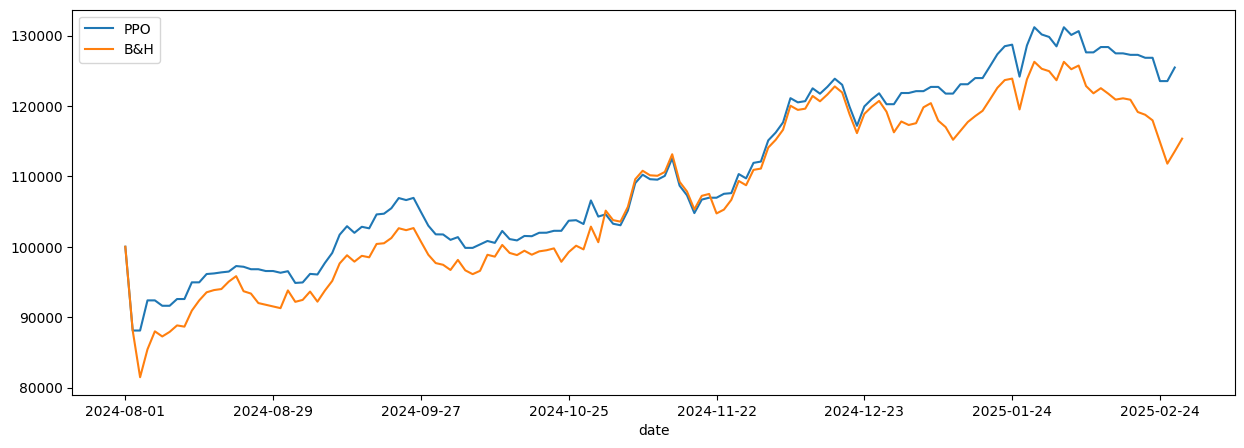

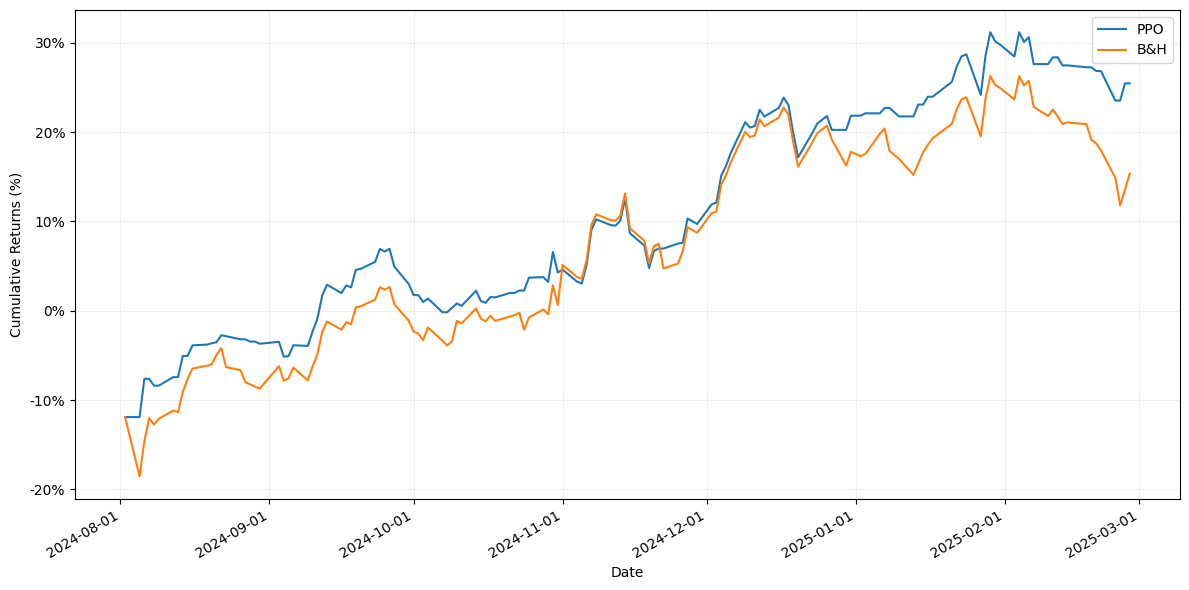

In [103]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Setting the figure size for the plot
plt.figure(figsize=(12, 6))

# Iterating through each strategy and plotting its cumulative returns
for strategy in strategies:
    if f'{strategy}_returns' in result.columns:
        # Make sure dates are properly parsed
        result.index = pd.to_datetime(result.index)
        
        # Extracting daily returns for the current strategy and converting to decimal format if necessary
        returns = result[f'{strategy}_returns'].dropna() + 1  # Adds 1 for using cumprod()
        
        # Calculating cumulative returns and converting to percentage
        cumulative_returns = (returns.cumprod() - 1) * 100  # Convert to percentage
        
        # Plotting cumulative returns with original colors
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
plt.ylabel('Cumulative Returns (%)')
plt.xlabel('Date')

# Format x-axis dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Make sure dates are in the correct format and rotated
plt.gcf().autofmt_xdate()

# Adding title and legend
#plt.title('Cumulative Returns of DRL Strategies')
plt.legend(loc='upper right')

# Add grid with light gray color
plt.grid(True, linestyle='-', alpha=0.2)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Displaying the plot
plt.show()

### Saving results to CSV
Needs to be changed for each agent

In [104]:
import pickle

# For df_account_value_sac
with open('results/5. AMZN/amzn_primorl_df_account_value_ppo.pkl', 'wb') as f:
    pickle.dump(df_account_value_ppo, f)
    
# For df_actions_td3
with open('results/5. AMZN/amzn_primorl_df_actions_ppo.pkl', 'wb') as f:
    pickle.dump(df_actions_ppo, f)

# For buy_and_hold
with open('results/5. AMZN/amzn_primorl_buy_and_hold.pkl', 'wb') as f:
    pickle.dump(buy_and_hold, f)